# R&D phase: About this notebook
- This notebooks support both CLASSIFICATION and REGRESSION
- Purpose: TRAINS a model with Azure AutoML and with AZURE compute cluster and calculates test_set scoring, automatically compares if newly trained model is better.
    - To iteratively try different ML-algorithms see what's best, change performance settings, train again.
    - Also to try different apporoaches, classification or regression approach - which is better for the use case.

- Q: `WHEN to move on form R&D phase to PRODUCTION phase notebook?`
    - When you are happy with the MODEL (or if you have a big dataset that requires pipeline for training) - then go to the next notebook `2a_PRODUCTION_phase` to create PIPELINES: 
        - PRODUCTION PHASE & MLOps requires 1 `training pipeline`, and a `scoring pipeline` or `scoring online endpoint`, for inference 
- This notebook - Details:
    - 1) Automaps data as Azure ML datasets. Based on your `lake_settings.json`
    - 2) Splits the GOLD data into 3 buckets. 
        - NB this is done with local compute, not Azure, use 
             - Option 1: `2a_PRODUCTION_phase` training pipeline if data is too big for local RAM memory
             - Option 2: Stay in this notebook & local split of data, but increase RAM memory of your/this Azure VM developer (DSVM) computer.
             - Option 2: Stay in this notebook & local split of data, but reduce data size. Only use a sample .parquet (or .csv) file in the IN-folder.
    - 3) Trains model
    - 4) Registers model
    - 5) Calculate test_set scoring
    - 6) Deploys model - ONLINE endpoint to AKS
    - 7) Inference: Smoke testing, using the ONLINE endpoint - get result back, saves the result to datalake also
    - DONE.
    
- This notebook is called: `M10_v143_esml_classification_1_train_env_dev.ipynb` in the notebook_templates folder
 

# NB ! You need to run Azure machine learnig workspace in `v1_legacy_mode=True`

In [ ]:
# Uncomment below row, Run this one time.
#p.ws.update(v1_legacy_mode=True) # If you happen to have a workspace in v2 mode, and want to change back to v1 legacy mode. 

# Login / Switch DEV_TEST_PROD environment (1-timer)

In [1]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/esml/common/")
from azureml.core.authentication import InteractiveLoginAuthentication
from esml import ESMLProject

p = ESMLProject()
p.dev_test_prod="dev"

print(p.tenant)
print(p.workspace_name) # self.workspace_name,subscription_id = self.subscription_id,resource_group = self.resource_group
print(p.subscription_id)
print(p.resource_group)

auth = InteractiveLoginAuthentication(force=True, tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)
p.ws = ws

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL
846f02b7-f92a-4053-9a99-094e5ba2e1a4
aml-prj001-weu-DEV-001
50ef5835-c45a-4c2e-a596-2a9e0e2a0a33
dc-heroes-esml-project001-weu-DEV-001-rg
Performing interactive authentication. Please follow the instructions on the terminal.
Interactive authentication successfully completed.


# TODO for you: CONFIGURATION
- 1) Change `p.active_model=11` to correct model number `1` if your model has that number.
        - See  [lake_settings.json](./settings/project_specific/model/lake_settings.json) to find YOUR model number.
        - Example: `model_number: 10`
- 2) Verify/Change `param_scoring_folder_date` and `param_train_in_folder_date` to correct `datalake datefolder folder`, in UTC format
        - The ESML admin should already have added data to your date folder `1000/01/01` for all your datasets, both under `train` folder and under `inference/0/` folder structure.
- 3) Create YOUR feature engineering logic, in the CELL in this notebook. Cell location: [2b) TODO 4 YOU - Your feature engineering](#2b_your_feature_engineering)
        - See  [lake_settings.json](./settings/project_specific/model/lake_settings.json) to find YOUR dataset names in the `dataset_folder_names` array
        - Example: `dataset_folder_names: ["ds01_titanic","ds02_haircolor","ds03_housing","ds04_lightsaber"]`

# 1) ESML - TRAIN Classification or Regression, with AutoML
DEMO models: 
- M10: TITANIC model use case, "predict survival or not".
- M11: Diabetes regression use case

This notebook works for your model also. It is a generic template

In [1]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/")
from esmlfac.adapter import ESMLFactory
sys.path.insert(0, "../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLProject
import pandas as pd

param_esml_env = "dev" 
param_inference_model_version = "1" # DATALAKE(my_model/inference/active) | settings/project_specific/active/active_scoring_in_folder.json
param_scoring_folder_date = "1000-01-01 00:00:01.243860" # DATALAKE(my_model/inference/active) | settings/project_specific/active/active_scoring_in_folder.json
param_train_in_folder_date = "1000-01-01 00:00:01.243860" # DATALAKE(my_model/train/active) | settings/project_specific/active/active_in_folder.json

p = ESMLProject(param_esml_env,param_inference_model_version,param_scoring_folder_date,param_train_in_folder_date)
#p = ESMLProject() # Alternatively use empty contructor, which takes parameters from settings\project_specific\model\active\active_in_folder.json

p.active_model = 11
p.inference_mode = False
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace
p.verbose_logging = False

# Init a ESMLController from ESMLProject configuration: Needed for 
datastore = p.connect_to_lake() # Connects to the correct ALDS GEN 2 storage account (DEV, TEST or PROD)
controller = ESMLFactory.get_esml_controller_from_notebook(p)
#p.describe()

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL
Using GEN2 as Datastore
use_project_sp_2_mount: True
Searching for setting in ESML datalake...
ESML in-folder settings override = TRUE 
 - Found settings in the ESML AutoLake  [active_in_folder.json,active_scoring_in_folder.json], to override ArgParse/GIT config with.
 - TRAIN in date:  1000/01/01
 - INFERENCE in date: 1000/01/01 and ModelVersion to score with: 0 (0=latest)
...


## "One time a day" - the below is needed to be done, to ensure Azure ML v1

In [2]:
print("NB! The below command you only need to run 1 time a day - then you can disable this cell. comment the code lines")
print("")
p.ws.update(v1_legacy_mode=True)

NB! The below command you only need to run 1 time a day - then you can disable this cell. comment the code lines



{'id': '/subscriptions/50ef5835-c45a-4c2e-a596-2a9e0e2a0a33/resourceGroups/dc-heroes-esml-project001-weu-dev-001-rg/providers/Microsoft.MachineLearningServices/workspaces/aml-prj001-weu-dev-001',
 'name': 'aml-prj001-weu-dev-001',
 'identity': {'principal_id': '32f3a889-570a-404b-bd49-29d7b761aa13',
  'tenant_id': '846f02b7-f92a-4053-9a99-094e5ba2e1a4',
  'type': 'SystemAssigned'},
 'location': 'westeurope',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {'Application Name': 'Enterprise Scale ML (ESML)',
  'BA ID': 'NA',
  'BCIO': 'Robin',
  'Business Area': 'NA',
  'Cost Center': '123456',
  'Resource Managed By': 'The Riddler',
  'TechnicalContact': 'batman@gothamcity.dc_',
  'Project': 'Batcave upgrade',
  'Description': 'ESML AI Factory'},
 'sku': 'Basic',
 'workspaceid': '14329cb6-9c78-4714-89e1-5bde1f975f93',
 'sdkTelemetryAppInsightsKey': '9ac578de-874f-4fea-85bc-7e4cefd0d47f',
 'description': 'Azure ML workspace for prj001 in ESML-dev environment. In AI Facto

### Below is optional - if you want to start over / clean your DATA sets registry

In [ ]:
unregister_all_datasets=False
if(unregister_all_datasets):
    p.unregister_all_datasets(p.ws) # For DEMO purpose

## 2) CUSTOMIZE - FEATURE ENGINEERING (classification or regression)

### 2a) DEMO feature engineering: Models M10, M11

In [2]:
def feature_engieering_regression_m11():
    # Feture engineering: Bronze 2 Gold - working with Azure ML Datasets with Bronze, Silver, Gold concept
    esml_dataset = p.DatasetByName("ds01_diabetes") # Get dataset
    df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
    p.save_silver(esml_dataset,df_bronze)  #Bronze -> Silver: ESML saves and registers as Azure ML Datasets.

    esml_dataset2 = p.DatasetByName("ds02_other") # Get dataset
    df_bronze2 = esml_dataset2.Bronze.to_pandas_dataframe()
    p.save_silver(esml_dataset2,df_bronze2)  #Bronze -> Silver: ESML saves and registers as Azure ML Datasets.

    df = esml_dataset.Silver.to_pandas_dataframe() 
    df_filtered = df[df.AGE > 0.015] 
    gold = p.save_gold(df_filtered)  # Silver -> Gold: ESML saves and registers as Azure ML Datasets.
    return gold

def feature_engieering_classification_m10():
    # R&D purpose: Try some data wrangling here...we will later incorporate this in an Azure ML Pipeline, as "steps"
    esml_dataset = p.DatasetByName("ds01_titanic") 
    df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
    df_bronze.columns = df_bronze.columns.str.replace("[/]", "_") # Rename werid column names

    silver_aml_dataset = p.save_silver(esml_dataset,df_bronze) #Bronze -> Silver: ESML saves and registers as Azure ML Datasets. (esml_dataset.Silver == silver_aml_dataset)

    esml_dataset2 = p.DatasetByName("ds02_haircolor")
    esml_dataset3 = p.DatasetByName("ds03_housing")
    esml_dataset4 = p.DatasetByName("ds04_lightsaber")

    p.save_silver(esml_dataset2,esml_dataset2.Bronze.to_pandas_dataframe()) #Bronze -> Silver: ESML saves and registers as Azure ML Datasets.
    p.save_silver(esml_dataset3,esml_dataset3.Bronze.to_pandas_dataframe()) #Bronze -> Silver:ESML saves and registers as Azure ML Datasets.
    p.save_silver(esml_dataset4,esml_dataset4.Bronze.to_pandas_dataframe()) #Bronze -> Silver:ESML saves and registers as Azure ML Datasets.

    gold_aml_dataset = p.save_gold(esml_dataset.Silver.to_pandas_dataframe())  #Silver -> Gold: ESML saves and registers as Azure ML Datasets.
    return gold_aml_dataset # p.Gold

### About: YOUR feature engineering: Models M01, M02, ...
- Note: When you are happy with the code in CURRENT notebook, and are going to PRODUCTION PHASE [2_PRODUCTION_phase_TRAIN_Pipeline_M10_M11.ipynb](./1_quickstart/2_PRODUCTION_phase_TRAIN_Pipeline_M10_M11.ipynb), then just copy and paste this code into a `your_custom_code.py` which resides in the pipeline SNAPSHOT FOLDER `M01` code that will run in the PIPELINE
    - Example of location of file, in pipeline snapshot folder: 01_pipelines\batch\\`M11`\\your_code\your_custom_code.py
    - The code in this cell below, you can add as static methods to a CLASS in the `your_custom_code.py` after you have genereated the snapshot folder.
    - Q: How to generate snapshot folder? I cannot see  `01_pipelines\batch\\`M11`\\your_code\your_custom_code.py`
        - A: See notebook [2_PRODUCTION_phase_TRAIN_Pipeline_M10_M11.ipynb](./1_quickstart/2_PRODUCTION_phase_TRAIN_Pipeline_M10_M11.ipynb)

...but lets leave all that for later, lets get back to THIS notebook, and the R&D phase, where it is easier to just have the code in a cell, a below.

# 2b) TODO 4 YOU: CUSTOMIZE - Your feature engineering
<a id='2b_your_feature_engineering'></a>
- See  [lake_settings.json](./settings/project_specific/model/lake_settings.json) to find YOUR dataset names in the `dataset_folder_names` array
    - Example: `dataset_folder_names: ["ds01_titanic","ds02_haircolor","ds03_housing","ds04_lightsaber"]`

In [3]:
print('Label is: {}'.format(p.active_model["label"]))
print('ml_type / task is: {}'.format(p.active_model["ml_type"]))
print('dataset_folder_names are: {}'.format(p.active_model["dataset_folder_names"]))

Label is: Y
ml_type / task is: regression
dataset_folder_names are: ['ds01_diabetes', 'ds02_other']


In [4]:
#ESML INFO: You are now in R&D phase / notbook. When in PRODUCITON phase/notebook - copy the code/methods below as a clas in 'your_custom_code.py', in your models snapshot folder.
def ds01_process_in2silver(df_bronze):
    df_silver = df_bronze

    # TODO: Customize this logic, to target YOUR model    
    df_silver.columns = df_silver.columns.str.replace("[/]", "_") # Rename werid column names.
    # ...
    # ...
    return df_silver

def ds02_process_in2silver(df_2_bronze = None):
    df2_silver = df_2_bronze
    # TODO: Customize this logic, to target YOUR model
    return df2_silver # Optional, you can have 1 dataset, or 50...

def merge_silvers_2_gold(df_silver, df2_silver = None):
    df_gold_state = None
    if (df2_silver is not None):# merge multiple datasets?
        #df_gold_state = pd.merge(df_silver, df2_silver, left_on='Xyz', right_on='Zxy') # TODO: Customize this logic, to target YOUR model
        df_gold_state = df_silver
    else: # just save the 1 silver, as gold, since only 1 dataset exists
        df_gold_state = df_silver
    return df_gold_state

def your_feature_engieering():

    # 1) Fetch 1-M datasets
    ds01_name = p.active_model["dataset_folder_names"][0]
    esml_dataset = p.DatasetByName(ds01_name) # Edit in lake_settings.json - print(p.active_model["dataset_folder_names"])
    esml_dataset2 = None

    try:
        ds02_name = p.active_model["dataset_folder_names"][1]
        esml_dataset2 = p.DatasetByName(ds02_name)
    except:
        print("Seems like you don't have anymore datasets, only 1.")
    
    # 2) Do some feature engineering & save BRONZE-> SILVER
    df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
    df_silver_state = ds01_process_in2silver(df_bronze)
    aml_dataset_silver = p.save_silver(esml_dataset,df_silver_state) # ESML saves and registers as Azure ML Datasets. Do not do this in PRODUCTION PHASE (your_custom_code.py) since pipeline will do this for you. just return the PANDAS dataframe gold_state

    df_silver = esml_dataset.Silver.to_pandas_dataframe() #  'aml_dataset_silver.to_pandas_dataframe()' would be same thing as 'esml_dataset.Silver.to_pandas_dataframe()'
    df2_silver = None
    if (esml_dataset2 is not None):# multiple datasets?
        df2_bronze = esml_dataset2.Bronze.to_pandas_dataframe()
        df2_silver_state = ds02_process_in2silver(df2_bronze)
        aml_dataset2_silver = p.save_silver(esml_dataset2,df2_silver_state) # ESML saves and registers as Azure ML Datasets. Do not do this in PRODUCTION PHASE (your_custom_code.py) since pipeline will do this for you
        df2_silver = aml_dataset2_silver.to_pandas_dataframe() #  'aml_dataset_silver.to_pandas_dataframe()' would be same thing as 'esml_dataset.Silver.to_pandas_dataframe()'
            
    # 3) Merge SILVER datasets to GOLD
    df_gold_state = merge_silvers_2_gold(df_silver,df2_silver)
    
    gold = p.save_gold(df_gold_state)  # ESML saves and registers as Azure ML Datasets.  Do not do this in PRODUCTION PHASE (your_custom_code.py), just return the PANDAS dataframe gold_state
    return gold
    

# CUSTOMIZE ------ END

## Connect to DATALAKE, call FEATURE ENGINEERING
- DEMO logic: If not the first time, then just CONNECT to lake. If first time, then also call feature engineering

In [5]:
p.active_model

{'model_number': 11,
 'model_folder_name': '11_diabetes_model_reg',
 'model_short_alias': 'M11',
 'dataset_folder_names': ['ds01_diabetes', 'ds02_other'],
 'label': 'Y',
 'ml_type': 'regression',
 'ml_metric': 'normalized_mean_absolute_error',
 'ml_time_out_score': 0.3}

In [6]:
datastore = None
always_run_feature_engineering = True

model_number = p.active_model["model_number"]

if(always_run_feature_engineering):
    datastore = p.init() # 3) Automapping from datalake to Azure ML datasets
    if (p.active_model["model_number"] == 10):
        gold_aml_dataset = feature_engieering_classification_m10()
    elif (p.active_model["model_number"] == 11):
        gold_aml_dataset = feature_engieering_regression_m11()
    elif((model_number > 0) and (model_number < 10)):
        gold_aml_dataset = your_feature_engieering()
else: # Only run feature engineering,1st time e.g. if data is splitted to GoldTrain
    try:
        datastore = p.connect_to_lake() # Connects to the correct ALDS GEN 2 storage account (DEV, TEST or PROD)
        gold_train = p.GoldTrain
        gold_train.name
        print("Not 1st time. We have data mapped already...and splitted. Now connected to LAKE")
    except: # If 1st time....no Gold exists, nor any mapping
        print("1st time. Lets init, map what data we have in LAKE, as Azure ML Datasets")
        datastore = p.init() # 3) Automapping from datalake to Azure ML datasets
        if (p.active_model["model_number"] == 10):
            gold_aml_dataset = feature_engieering_classification_m10()
        elif (p.active_model["model_number"] == 11):
            gold_aml_dataset = feature_engieering_regression_m11()
        elif((model_number > 0) and (model_number < 10)): # TODO: Customize this logic, to target YOUR model
            gold_aml_dataset = your_feature_engieering()  # TODO: Customize this logic, to target YOUR models feature engineering

Using GEN2 as Datastore
use_project_sp_2_mount: True
Searching for setting in ESML datalake...
ESML in-folder settings override = TRUE 
 - Found settings in the ESML AutoLake  [active_in_folder.json,active_scoring_in_folder.json], to override ArgParse/GIT config with.
 - TRAIN in date:  1000/01/01
 - INFERENCE in date: 1000/01/01 and ModelVersion to score with: 0 (0=latest)

Inference mode (False = Training mode): False
Load data as Datasets....
ds01_diabetes
ds02_other

####### Automap & Autoregister - SUCCESS!
1) Auto mapped 2 ESML Dataset with registered Azure ML Datasets (potentially all 3: IN,BRONZE, SILVER) in Datastore esmlprojectstore 

Dataset 'ds01_diabetes' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files
Dataset 'ds02_other' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files

2) Registered each Dataset with suffixes (_IN, _BRONZE, _SILVER) 
 Tip: Use ESMLProject.Datasets list or .DatasetByName(myDatasetNa

In [7]:
p.Gold.to_pandas_dataframe().head()

AGE      SEX       BMI        BP        S1        S2        S3  \
0  0.038076  0.05068  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1  0.085299  0.05068  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
2  0.063504  0.05068 -0.001895  0.066630  0.090620  0.108914  0.022869   
3  0.041708  0.05068  0.061696 -0.040099 -0.013953  0.006202 -0.028674   
4  0.027178  0.05068  0.017506 -0.033214 -0.007073  0.045972 -0.065491   

         S4        S5        S6      Y  
0 -0.002592  0.019908 -0.017646  151.0  
1 -0.002592  0.002864 -0.025930  141.0  
2  0.017703 -0.035817  0.003064   63.0  
3 -0.002592 -0.014956  0.011349  110.0  
4  0.071210 -0.096433 -0.059067   69.0

## SUMMARY - step 1, 2
- ESML has now `Automap` and `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`
- ESML has read configuration for correct environment (DEV, TEST, PROD). 
    - Both small customers, and large Enterprise customers often wants:  DEV, TEST, PROD in `diffferent Azure ML workspaces` (and different subscriptions)
- User has done feature engineering, and saved GOLD `p.save_gold`

In [8]:
print("rows in GOLD {}".format(p.Gold.to_pandas_dataframe().shape[0]))

rows in GOLD 185


### SPLIT option A) ESML default split logic, which you can override

In [9]:
M10_GOLD_TRAIN, M10_GOLD_VALIDATE, M10_GOLD_TEST = p.split_gold_3(0.6,label=p.active_model["label"],stratified=False) # Splits and Auto-registers as AZUREM ML Datasets

...


### SPLIT option B) Use YOUR split logic, override the default
- You need to create your own class (ESMLSplitter is just an example class) such as MySplitter(IESMLSplitter)

In [10]:
import sys
sys.path.insert(0, "../azure-enterprise-scale-ml/")

from esmlrt.interfaces.iESMLSplitter import IESMLSplitter # Just for reference to see where the abstract class exists
from esmlrt.runtime.ESMLSplitter import ESMLSplitter1 # Point at your own code/class here instead..that needst to implement the IESMLSplitter class

my_IESMLSplitter = ESMLSplitter1()
M10_GOLD_TRAIN, M10_GOLD_VALIDATE, M10_GOLD_TEST = p.split_gold_3(train_percentage=0.6,label=p.active_model["label"],stratified=False,override_with_custom_iESMLSplitter=my_IESMLSplitter) # Splits and Auto-registers as AZUREM ML Datasets

...


# IN_2_GOLD
- If just wanting to refine data to GOLD, for a Power BI report (No ML involved)
- Scenario: You want to refine data from "IN_2_GOLD" with an easy way to READ/WRITE data (using the enterprise datalake via ESML AutoLake and ESML SDK)

In [11]:
p.GoldTrain.to_pandas_dataframe().head()  # Azure ML Dataset

AGE       SEX       BMI        BP        S1        S2        S3  \
0  0.034443 -0.044642 -0.007284  0.014987 -0.044223 -0.037326 -0.002903   
1  0.019913  0.050680  0.014272  0.063187  0.014942  0.020293 -0.047082   
2  0.019913 -0.044642 -0.057941 -0.057314 -0.001569 -0.012587  0.074412   
3  0.074401  0.050680 -0.020218  0.045972  0.074108  0.032819 -0.036038   
4  0.081666  0.050680 -0.002973 -0.033214  0.042462  0.057871 -0.010266   

         S4        S5        S6      Y  
0 -0.039493 -0.021394  0.007207  155.0  
1  0.034309  0.046661  0.090049  297.0  
2 -0.039493 -0.061177 -0.075636   63.0  
3  0.071210  0.106354  0.036201  241.0  
4  0.034309 -0.000609 -0.001078  139.0

# 3) `ESML` Train model in `5 codelines`

In [12]:
print("We are in environment {}".format(p.dev_test_prod))
# Lets look at our AutoML performance settings:
automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
automl_performance_config

We are in environment dev
Loading AutoML config settings from: dev


{'enable_voting_ensemble': True,
 'enable_stack_ensemble': False,
 'model_explainability': True,
 'experiment_timeout_hours': 0.75,
 'iteration_timeout_minutes': 5,
 'n_cross_validations': 3,
 'enable_early_stopping': False,
 'iterations': 100,
 'max_cores_per_iteration': -1,
 'allowed_models': ['LightGBM', 'DecisionTree', 'ExtremeRandomTrees', 'KNN'],
 'path': '.',
 'debug_log': 'azure_automl_debug_dev.log'}

Lets look at our label, and our machine learning task type:

In [13]:
print('Label is: {}'.format(p.active_model["label"]))
print('ml_type / task is: {}'.format(p.active_model["ml_type"]))
print('dataset_folder_names are: {}'.format(p.active_model["dataset_folder_names"]))

Label is: Y
ml_type / task is: regression
dataset_folder_names are: ['ds01_diabetes', 'ds02_other']


### Lets TRAIN with AutoML & Azure compute cluster (M11 demo takes ~ 10-15min)

In [14]:
from esml import ESMLProject
from baselayer_azure_ml import AutoMLFactory,azure_metric_regression,azure_metric_classification
from azureml.train.automl import AutoMLConfig

automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
aml_compute = p.get_training_aml_compute(p.ws) # 2)Get compute, for active environment

automl_config = AutoMLConfig(task = p.active_model["ml_type"], # 4) Override the ENV config, for model(that inhertits from enterprise DEV_TEST_PROD config baseline)
                            primary_metric = p.active_model["ml_metric"], #  Note: Regression[MAE, RMSE,R2,Spearman] Classification[AUC,Accuracy,Precision,Precision_avg,Recall]
                            compute_target = aml_compute,
                            training_data = p.GoldTrain, # is 'train_6' pandas dataframe, but as an Azure ML Dataset
                            experiment_exit_score = p.active_model["ml_time_out_score"], # DEMO purpose. remove experiment_exit_score if you want to have good accuracy (put a comment # on this row to remove it)
                            label_column_name = p.active_model["label"],
                            **automl_performance_config
                        )

best_run, fitted_model, experiment = AutoMLFactory(p).train_as_run(automl_config)

Loading AutoML config settings from: dev
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Using a model specific cluster, per configuration in project specific settings, (the integer of 'model_number' is the base for the name)
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Creating new cluster - p001-m11weu-dev
InProgress..
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
image_build_compute = p001-m11weu-dev
Experiment name: 11_diabetes_model_reg
Azure ML Studio Workspace: aml-prj001-weu-DEV-001
Start training run...
Submitting remote run.
No run_configuration provided, running on p001-m11weu-d


Current status: FeaturesGeneration. Generating features for the dataset.
Current status: ModelSelection. Beginning model selection.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

********************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.
              Learn more about high cardinality feature handling: https://aka.ms/AutomatedMLFeaturization

********************************************************************************************

*********************************************************

## 4) ESML Scoring Drift/Concept Drift: Compare with `1-codeline`: Promote model or not? If better, then `Register model`
- `IF` newly trained model in `current` environment (`DEV`, `TEST` or `PROD`) scores BETTER than existing model in `target` environment, then `new model` can be registered and promoted.
- Q: Do we have `SCORING DRIFT / CONCEPT DRIFT?`
- Q: Is a model trained on NEW data better? IS the one in production degraded? (not fit for the data it scores - real world changed, other CONCEPT)
- A: - Lets check. Instead of `DataDrift`, lets look at `actual SCORING` on new data (and/or new code, feature engineering) - See if we should PROMOTE newly trained model...

In [15]:
print("current AI Factory environment: '{}' - AML WS: '{}'".format(p.dev_test_prod, p.ws.name))

current AI Factory environment: 'dev' - AML WS: 'aml-prj001-weu-DEV-001'


#### Check if we already have a MODEL with a suitable NAME - to gruoup ur runs and model versions under.
- Purpose: Gets consitent model name, if many runs

In [16]:
from esmlrt.interfaces.iESMLController import IESMLController
current_model,run_id_tag, model_name = IESMLController.get_best_model_via_modeltags_only_DevTestProd(p.ws,controller.experiment_name)

if(current_model is None):
    print("No existing model with experiment name {}. The Model name will now be same as experiment name".format(controller.experiment_name))
    current_model = None
    run_id_tag = ""
    model_name = controller.experiment_name
else:
    print("Current BEST model is: {} from Model registry with experiment_name-TAG {}, run_id-TAG {}  model_name-TAG {}".format(current_model.name,controller.experiment_name,run_id_tag,model_name))
    if ("esml_time_updated" in current_model.tags):
        print("esml_time_updated: {}".format(current_model.tags.get("esml_time_updated")))
    print("status_code : {}".format(current_model.tags.get("status_code")))
    print("model_name  : {}".format(current_model.tags.get("model_name")))
    print("trained_in_workspace   : {}".format(current_model.tags.get("trained_in_workspace")))

Searching with Model list LAMBDA FILTER, on experiment_name in Model.tags called: 11_diabetes_model_reg . Meaning ESML checks for both Notebook run (AutoMLRun, Run) and PipelineRuns (AutoMLStep, PipelineRun)
E.g. Even if Pipeline experiment is called '11_diabetes_model_reg_IN_2_GOLD_TRAIN' it will be included, since original model_folder_name in ESML is '11_diabetes_model_reg' as a notebook Run experiment name. Both is included in search
Filter search, minutes: 0.019215659300486247
list index out of range
Cannot find tag 'experiment_name' on all models, hence cannot use optimized search, looping manually now...
TIME: Model list LOOP filter, on experiment_name
Minutes: 0.020968210697174073
Could not find tags, run_id or model_name on model_highest_version
'NoneType' object has no attribute 'tags'
No existing model with experiment name 11_diabetes_model_reg. The Model name will now be same as experiment name


##### Register new trained model, as NEW: not promoted.
 - Purpose: To be able to TAG scoring on it

In [17]:
from esmlrt.interfaces.iESMLController import IESMLController
import datetime

time_stamp = str(datetime.datetime.now())
ml_flow_stage = IESMLController._get_flow_equivalent(IESMLController.esml_status_new)

tags = {"esml_time_updated": time_stamp,"status_code": IESMLController.esml_status_new,"mflow_stage":ml_flow_stage, "run_id": best_run.id, "model_name": model_name, "trained_in_environment": controller.dev_test_prod, 
    "trained_in_workspace": p.ws.name, "experiment_name": controller.experiment_name, "trained_with": "AutoMLRun"}

model = best_run.register_model(model_name=model_name, tags=tags, description="", model_path=".")
print("model.name", model.name)
print("model.version", model.version)
#model_path = None
#model = controller._register_aml_model(model_path,model_name,tags,ws,"")

model.name 11_diabetes_model_reg
model.version 1


## 5) TEST SET SCORING: Calculate test_set SCORING
- Is tagged on MODEL in Azure ML Studio

### Rehydrate RUN - to calulate test_scoring
- if you restarted notebook, and dont want to wait for TRAIN again, you can fetch RUN, FITTED_MODEL, AML_MODEL as below

In [8]:
print(controller.experiment_name)
print(p.experiment_name)

11_diabetes_model_reg
11_diabetes_model_reg


In [10]:
from azureml.core import Experiment

exp = Experiment(p.ws,"11_diabetes_model_reg")

In [11]:
exp.workspace.name

'aml-prj001-weu-DEV-001'

In [17]:
from azureml.core import Model
from esmlrt.interfaces.iESMLController import IESMLController

if(p.active_model["ml_type"] == "regression"):
    your_model_id = "11_diabetes_model_reg" # See Azure ML Studio - Models registry, 1st column in table
    models_run_id = "0431fa5b-f342-4d7f-aaa6-fe1900fa45ef" # Regression: See Azure ML Studio - Models registry, 2nd column in table. If empty, see JOBS id for run_id
elif(p.active_model["ml_type"] == "classification"):
    your_model_id = "AutoML3a56468360"
    models_run_id = "AutoML_3a564683-6824-4ca9-b07d-71652d445da6_0" # Classification

model = Model(p.ws, your_model_id)
run,best_run,fitted_model = IESMLController.init_run(p.ws,controller.experiment_name, models_run_id)


ESML INFO: try: automl_run or notebook_automl
Experiment name: 11_diabetes_model_reg
ws name: aml-prj001-weu-DEV-001
run_id: 0431fa5b-f342-4d7f-aaa6-fe1900fa45ef
 ## ESML: AutoMLRun? 
 ## ESML: AutoMLRun = TRUE


In [18]:
print(best_run)

Run(Experiment: 11_diabetes_model_reg,
Id: 0431fa5b-f342-4d7f-aaa6-fe1900fa45ef_0,
Type: azureml.scriptrun,
Status: Completed)


In [19]:
print(run)

Run(Experiment: 11_diabetes_model_reg,
Id: 0431fa5b-f342-4d7f-aaa6-fe1900fa45ef,
Type: azureml.StepRun,
Status: Completed)


In [20]:
print(best_run.parent)

Run(Experiment: 11_diabetes_model_reg_pipe_IN_2_GOLD_TRAIN_AUTOML,
Id: 0431fa5b-f342-4d7f-aaa6-fe1900fa45ef,
Type: azureml.StepRun,
Status: Completed)


In [5]:
#model = best_run.parent.register_model(model_name="11_diabetes_model_reg") # Funkar EJ
#model = best_run.parent.register_model(model_name="11_diabetes_model_reg", model_path="outputs/") # Funkar!
#model = best_run.register_model(model_name="11_diabetes_model_reg", model_path="outputs/") # Funkar EJ - ERROR:azureml._restclient.models_client:Received bad response from Model Management Service: 400
model = best_run.parent.register_model(model_name="11_diabetes_model_reg", model_path="outputs") # Funkar: 2023
# model_name="model.pkl"

In [6]:
best_run

Run(Experiment: 11_diabetes_model_reg,
Id: 0431fa5b-f342-4d7f-aaa6-fe1900fa45ef_0,
Type: azureml.scriptrun,
Status: Completed)

In [10]:
print(best_run.parent)

Run(Experiment: 11_diabetes_model_reg_pipe_IN_2_GOLD_TRAIN_AUTOML,
Id: 0431fa5b-f342-4d7f-aaa6-fe1900fa45ef,
Type: azureml.StepRun,
Status: Completed)


In [12]:
print(run)

Run(Experiment: 11_diabetes_model_reg,
Id: 0431fa5b-f342-4d7f-aaa6-fe1900fa45ef,
Type: azureml.StepRun,
Status: Completed)


In [13]:
type(run)

azureml.train.automl.run.AutoMLRun

In [9]:
#model = run.register_model(model_name="11_diabetes_model_reg", model_path="outputs") # Funkar Ej: 'TypeError: register_model() got an unexpected keyword argument 'model_path''
model = run.register_model(model_name="11_diabetes_model_reg") # Funkar Ej: 'ERROR:azureml._restclient.models_client:Received bad response from Model Management Service:Response Code: 400'

ERROR:azureml._restclient.models_client:Received bad response from Model Management Service:
Response Code: 400
Correlation: {'operation': 'b2f7b27ec9c7fa4785e20e7c5de43e83', 'request': '836309eecfb1b82e', 'RequestId': '836309eecfb1b82e'}
Content: [<azureml._restclient.models.error_details.ErrorDetails object at 0x000001E009144850>]



WebserviceException: WebserviceException:
	Message: Received bad response from Model Management Service:
Response Code: 400
Correlation: {'operation': 'b2f7b27ec9c7fa4785e20e7c5de43e83', 'request': '836309eecfb1b82e', 'RequestId': '836309eecfb1b82e'}
Content: [<azureml._restclient.models.error_details.ErrorDetails object at 0x000001E009144850>]
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Received bad response from Model Management Service:\nResponse Code: 400\nCorrelation: {'operation': 'b2f7b27ec9c7fa4785e20e7c5de43e83', 'request': '836309eecfb1b82e', 'RequestId': '836309eecfb1b82e'}\nContent: [<azureml._restclient.models.error_details.ErrorDetails object at 0x000001E009144850>]"
    }
}

In [ ]:
model = best_run.parent.register_model(model_name="11_diabetes_model_reg", model_path="outputs") # Funkar: 2023

In [14]:
model_registered_in_target = controller.register_model(source_ws=p.ws, target_env="dev", source_model=model, run=best_run.parent,esml_status=IESMLController.esml_status_promoted_2_dev)

Connecting to env: dev
- ws name: aml-prj001-weu-DEV-001
- self._secret_name_tenant: esml-tenant-id
- self._secret_name_project_sp_id: esml-project-sp-id
- self._secret_name_project_sp_secret: esml-project-sp-secret
Connecting to env: dev
- ws name: aml-prj001-weu-DEV-001
- self._secret_name_tenant: esml-tenant-id
- self._secret_name_project_sp_id: esml-project-sp-id
- self._secret_name_project_sp_secret: esml-project-sp-secret
model_name at remote_run.register_model:  11_diabetes_model_reg
model_path (will override model_name when register) at remote_run.register_model:  None


ModelPathNotFoundException: ModelPathNotFoundException:
	Message: Could not locate the provided model_path 11_diabetes_model_reg in the set of files uploaded to the run: ['automl_driver.py', 'best_model_data', 'definition.json', 'definition_original.json', 'logs/azureml/executionlogs.txt', 'logs/azureml/stderrlogs.txt', 'logs/azureml/stdoutlogs.txt', 'metrics_data', 'outputs/_automl_internal/ExperimentData_lazy.pkl', 'outputs/_automl_internal/ExperimentData_materialized.pkl', 'outputs/_automl_internal/ExperimentData_partitioned.pkl', 'outputs/_automl_internal/ExperimentMetadata.pkl', 'outputs/_automl_internal/ExperimentMetadata_Classification.pkl', 'outputs/_automl_internal/ExperimentMetadata_Regression.pkl', 'outputs/_automl_internal/ExperimentMetadata_Timeseries.pkl', 'outputs/_automl_internal/X_raw.df.parquet', 'outputs/_automl_internal/X_raw_valid.pkl', 'outputs/_automl_internal/_CACHE_STORE_KEY_ONNX_CONVERTER_INIT_METADATA_.pkl', 'outputs/_automl_internal/featurized_cv_split_0.pkl', 'outputs/_automl_internal/featurized_cv_split_1.pkl', 'outputs/_automl_internal/featurized_cv_split_2.pkl', 'outputs/_automl_internal/indices/bc4594cec7c4419abc2a2967f57006d4.json', 'outputs/_automl_internal/indices/defe6a4745d740fa90b21753c900cba5.json', 'outputs/_automl_internal/split_keys.pkl', 'outputs/_automl_internal/y_raw.npys.parquet', 'outputs/_automl_internal/y_raw_valid.pkl', 'outputs/featurization/data/X_valid.pkl', 'outputs/featurization/data/full_training_dataset.df.parquet', 'outputs/featurization/data/sample_weight_valid.pkl', 'outputs/featurization/data/y_valid.pkl', 'outputs/featurization/pipeline/MLmodel', 'outputs/featurization/pipeline/conda.yaml', 'outputs/featurization/pipeline/model.pkl', 'outputs/featurization/pipeline/python_env.yaml', 'outputs/featurization/pipeline/requirements.txt', 'outputs/verifier_results.json']
                See https://aka.ms/run-logging for more details.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Could not locate the provided model_path 11_diabetes_model_reg in the set of files uploaded to the run: ['automl_driver.py', 'best_model_data', 'definition.json', 'definition_original.json', 'logs/azureml/executionlogs.txt', 'logs/azureml/stderrlogs.txt', 'logs/azureml/stdoutlogs.txt', 'metrics_data', 'outputs/_automl_internal/ExperimentData_lazy.pkl', 'outputs/_automl_internal/ExperimentData_materialized.pkl', 'outputs/_automl_internal/ExperimentData_partitioned.pkl', 'outputs/_automl_internal/ExperimentMetadata.pkl', 'outputs/_automl_internal/ExperimentMetadata_Classification.pkl', 'outputs/_automl_internal/ExperimentMetadata_Regression.pkl', 'outputs/_automl_internal/ExperimentMetadata_Timeseries.pkl', 'outputs/_automl_internal/X_raw.df.parquet', 'outputs/_automl_internal/X_raw_valid.pkl', 'outputs/_automl_internal/_CACHE_STORE_KEY_ONNX_CONVERTER_INIT_METADATA_.pkl', 'outputs/_automl_internal/featurized_cv_split_0.pkl', 'outputs/_automl_internal/featurized_cv_split_1.pkl', 'outputs/_automl_internal/featurized_cv_split_2.pkl', 'outputs/_automl_internal/indices/bc4594cec7c4419abc2a2967f57006d4.json', 'outputs/_automl_internal/indices/defe6a4745d740fa90b21753c900cba5.json', 'outputs/_automl_internal/split_keys.pkl', 'outputs/_automl_internal/y_raw.npys.parquet', 'outputs/_automl_internal/y_raw_valid.pkl', 'outputs/featurization/data/X_valid.pkl', 'outputs/featurization/data/full_training_dataset.df.parquet', 'outputs/featurization/data/sample_weight_valid.pkl', 'outputs/featurization/data/y_valid.pkl', 'outputs/featurization/pipeline/MLmodel', 'outputs/featurization/pipeline/conda.yaml', 'outputs/featurization/pipeline/model.pkl', 'outputs/featurization/pipeline/python_env.yaml', 'outputs/featurization/pipeline/requirements.txt', 'outputs/verifier_results.json']\n                See https://aka.ms/run-logging for more details."
    }
}

In [10]:
model_registered_in_target = controller.register_model(source_ws=p.ws, target_env="dev", source_model=model, run=best_run,esml_status=IESMLController.esml_status_promoted_2_dev, model_path='model.pkl') # ModelPathNotFoundException

'''
{
    "error": {
        "message": "Could not locate the provided model_path model.pkl in the set of files uploaded to the run: ['ESML_GOLD_TestSet_ActualPredicted_1673664197.png', 'automl_driver.py', 'explanation/01fc2af7/eval_data_viz.interpret.json', 'explanation/01fc2af7/expected_values.interpret.json', 'explanation/01fc2af7/features.interpret.json', 'explanation/01fc2af7/global_names/0.interpret.json', 'explanation/01fc2af7/global_rank/0.interpret.json', 'explanation/01fc2af7/global_values/0.interpret.json', 'explanation/01fc2af7/local_importance_values.interpret.json', 'explanation/01fc2af7/rich_metadata.interpret.json', 'explanation/01fc2af7/true_ys_viz.interpret.json', 'explanation/01fc2af7/visualization_dict.interpret.json', 'explanation/01fc2af7/ys_pred_viz.interpret.json', 'explanation/dc1d7f3d/eval_data_viz.interpret.json', 'explanation/dc1d7f3d/expected_values.interpret.json', 'explanation/dc1d7f3d/features.interpret.json', 'explanation/dc1d7f3d/global_names/0.interpret.json', 'explanation/dc1d7f3d/global_rank/0.interpret.json', 'explanation/dc1d7f3d/global_values/0.interpret.json', 'explanation/dc1d7f3d/local_importance_values.interpret.json', 'explanation/dc1d7f3d/rich_metadata.interpret.json', 'explanation/dc1d7f3d/true_ys_viz.interpret.json', 'explanation/dc1d7f3d/visualization_dict.interpret.json', 'explanation/dc1d7f3d/ys_pred_viz.interpret.json', 'logs/azureml/azureml_automl-child.log', 'logs/azureml/azureml_automl.log', 'outputs/conda_env_v_1_0_0.yml', 'outputs/engineered_feature_names.json', 'outputs/env_dependencies.json', 'outputs/featurization_summary.json', 'outputs/generated_code/conda_environment.yaml', 'outputs/generated_code/script.py', 'outputs/generated_code/script_run_notebook.ipynb', 'outputs/internal_cross_validated_models.pkl', 'outputs/model.pkl', 'outputs/pipeline_graph.json', 'outputs/run_id.txt', 'outputs/scoring_file_pbi_v_1_0_0.py', 'outputs/scoring_file_v_1_0_0.py', 'outputs/scoring_file_v_2_0_0.py', 'predicted_true', 'residuals', 'system_logs/cs_capability/cs-capability.log', 'system_logs/hosttools_capability/hosttools-capability.log', 'system_logs/lifecycler/execution-wrapper.log', 'system_logs/lifecycler/lifecycler.log', 'system_logs/metrics_capability/metrics-capability.log', 'system_logs/snapshot_capability/snapshot-capability.log', 'user_logs/std_log.txt']\n                See https://aka.ms/run-logging for more details."
    }
}
'''

Connecting to env: dev
- ws name: aml-prj001-weu-DEV-001
- self._secret_name_tenant: esml-tenant-id
- self._secret_name_project_sp_id: esml-project-sp-id
- self._secret_name_project_sp_secret: esml-project-sp-secret
Connecting to env: dev
- ws name: aml-prj001-weu-DEV-001
- self._secret_name_tenant: esml-tenant-id
- self._secret_name_project_sp_id: esml-project-sp-id
- self._secret_name_project_sp_secret: esml-project-sp-secret
model_name at remote_run.register_model:  11_diabetes_model_reg
model_path (will override model_name when register) at remote_run.register_model:  model.pkl


ModelPathNotFoundException: ModelPathNotFoundException:
	Message: Could not locate the provided model_path model.pkl in the set of files uploaded to the run: ['ESML_GOLD_TestSet_ActualPredicted_1673664197.png', 'automl_driver.py', 'explanation/01fc2af7/eval_data_viz.interpret.json', 'explanation/01fc2af7/expected_values.interpret.json', 'explanation/01fc2af7/features.interpret.json', 'explanation/01fc2af7/global_names/0.interpret.json', 'explanation/01fc2af7/global_rank/0.interpret.json', 'explanation/01fc2af7/global_values/0.interpret.json', 'explanation/01fc2af7/local_importance_values.interpret.json', 'explanation/01fc2af7/rich_metadata.interpret.json', 'explanation/01fc2af7/true_ys_viz.interpret.json', 'explanation/01fc2af7/visualization_dict.interpret.json', 'explanation/01fc2af7/ys_pred_viz.interpret.json', 'explanation/dc1d7f3d/eval_data_viz.interpret.json', 'explanation/dc1d7f3d/expected_values.interpret.json', 'explanation/dc1d7f3d/features.interpret.json', 'explanation/dc1d7f3d/global_names/0.interpret.json', 'explanation/dc1d7f3d/global_rank/0.interpret.json', 'explanation/dc1d7f3d/global_values/0.interpret.json', 'explanation/dc1d7f3d/local_importance_values.interpret.json', 'explanation/dc1d7f3d/rich_metadata.interpret.json', 'explanation/dc1d7f3d/true_ys_viz.interpret.json', 'explanation/dc1d7f3d/visualization_dict.interpret.json', 'explanation/dc1d7f3d/ys_pred_viz.interpret.json', 'logs/azureml/azureml_automl-child.log', 'logs/azureml/azureml_automl.log', 'outputs/conda_env_v_1_0_0.yml', 'outputs/engineered_feature_names.json', 'outputs/env_dependencies.json', 'outputs/featurization_summary.json', 'outputs/generated_code/conda_environment.yaml', 'outputs/generated_code/script.py', 'outputs/generated_code/script_run_notebook.ipynb', 'outputs/internal_cross_validated_models.pkl', 'outputs/model.pkl', 'outputs/pipeline_graph.json', 'outputs/run_id.txt', 'outputs/scoring_file_pbi_v_1_0_0.py', 'outputs/scoring_file_v_1_0_0.py', 'outputs/scoring_file_v_2_0_0.py', 'predicted_true', 'residuals', 'system_logs/cs_capability/cs-capability.log', 'system_logs/hosttools_capability/hosttools-capability.log', 'system_logs/lifecycler/execution-wrapper.log', 'system_logs/lifecycler/lifecycler.log', 'system_logs/metrics_capability/metrics-capability.log', 'system_logs/snapshot_capability/snapshot-capability.log', 'user_logs/std_log.txt']
                See https://aka.ms/run-logging for more details.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Could not locate the provided model_path model.pkl in the set of files uploaded to the run: ['ESML_GOLD_TestSet_ActualPredicted_1673664197.png', 'automl_driver.py', 'explanation/01fc2af7/eval_data_viz.interpret.json', 'explanation/01fc2af7/expected_values.interpret.json', 'explanation/01fc2af7/features.interpret.json', 'explanation/01fc2af7/global_names/0.interpret.json', 'explanation/01fc2af7/global_rank/0.interpret.json', 'explanation/01fc2af7/global_values/0.interpret.json', 'explanation/01fc2af7/local_importance_values.interpret.json', 'explanation/01fc2af7/rich_metadata.interpret.json', 'explanation/01fc2af7/true_ys_viz.interpret.json', 'explanation/01fc2af7/visualization_dict.interpret.json', 'explanation/01fc2af7/ys_pred_viz.interpret.json', 'explanation/dc1d7f3d/eval_data_viz.interpret.json', 'explanation/dc1d7f3d/expected_values.interpret.json', 'explanation/dc1d7f3d/features.interpret.json', 'explanation/dc1d7f3d/global_names/0.interpret.json', 'explanation/dc1d7f3d/global_rank/0.interpret.json', 'explanation/dc1d7f3d/global_values/0.interpret.json', 'explanation/dc1d7f3d/local_importance_values.interpret.json', 'explanation/dc1d7f3d/rich_metadata.interpret.json', 'explanation/dc1d7f3d/true_ys_viz.interpret.json', 'explanation/dc1d7f3d/visualization_dict.interpret.json', 'explanation/dc1d7f3d/ys_pred_viz.interpret.json', 'logs/azureml/azureml_automl-child.log', 'logs/azureml/azureml_automl.log', 'outputs/conda_env_v_1_0_0.yml', 'outputs/engineered_feature_names.json', 'outputs/env_dependencies.json', 'outputs/featurization_summary.json', 'outputs/generated_code/conda_environment.yaml', 'outputs/generated_code/script.py', 'outputs/generated_code/script_run_notebook.ipynb', 'outputs/internal_cross_validated_models.pkl', 'outputs/model.pkl', 'outputs/pipeline_graph.json', 'outputs/run_id.txt', 'outputs/scoring_file_pbi_v_1_0_0.py', 'outputs/scoring_file_v_1_0_0.py', 'outputs/scoring_file_v_2_0_0.py', 'predicted_true', 'residuals', 'system_logs/cs_capability/cs-capability.log', 'system_logs/hosttools_capability/hosttools-capability.log', 'system_logs/lifecycler/execution-wrapper.log', 'system_logs/lifecycler/lifecycler.log', 'system_logs/metrics_capability/metrics-capability.log', 'system_logs/snapshot_capability/snapshot-capability.log', 'user_logs/std_log.txt']\n                See https://aka.ms/run-logging for more details."
    }
}

In [6]:

#model_registered_in_target = controller.register_model(source_ws=p.ws, target_env="dev", source_model=model, run=best_run,esml_status=IESMLController.esml_status_promoted_2_dev, model_path='outputs/model.pkl')

'''
{
    "error": {
        "message": "Received bad response from Model Management Service:\nResponse Code: 400\nCorrelation: {'operation': '0b0c23f10e9feea1b331bf65405946ef', 'request': '830d14e319f6449c', 'RequestId': '830d14e319f6449c'}\nContent: [<azureml._restclient.models.error_details.ErrorDetails object at 0x000002A8E9D7ED90>]"
    }
}
'''

Connecting to env: dev
- ws name: aml-prj001-weu-DEV-001
- self._secret_name_tenant: esml-tenant-id
- self._secret_name_project_sp_id: esml-project-sp-id
- self._secret_name_project_sp_secret: esml-project-sp-secret
Connecting to env: dev
- ws name: aml-prj001-weu-DEV-001
- self._secret_name_tenant: esml-tenant-id
- self._secret_name_project_sp_id: esml-project-sp-id
- self._secret_name_project_sp_secret: esml-project-sp-secret
model_name at remote_run.register_model:  11_diabetes_model_reg
model_path (will override model_name when register) at remote_run.register_model:  outputs/model.pkl


ERROR:azureml._restclient.models_client:Received bad response from Model Management Service:
Response Code: 400
Correlation: {'operation': '0b0c23f10e9feea1b331bf65405946ef', 'request': '830d14e319f6449c', 'RequestId': '830d14e319f6449c'}
Content: [<azureml._restclient.models.error_details.ErrorDetails object at 0x000002A8E9D7ED90>]



WebserviceException: WebserviceException:
	Message: Received bad response from Model Management Service:
Response Code: 400
Correlation: {'operation': '0b0c23f10e9feea1b331bf65405946ef', 'request': '830d14e319f6449c', 'RequestId': '830d14e319f6449c'}
Content: [<azureml._restclient.models.error_details.ErrorDetails object at 0x000002A8E9D7ED90>]
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Received bad response from Model Management Service:\nResponse Code: 400\nCorrelation: {'operation': '0b0c23f10e9feea1b331bf65405946ef', 'request': '830d14e319f6449c', 'RequestId': '830d14e319f6449c'}\nContent: [<azureml._restclient.models.error_details.ErrorDetails object at 0x000002A8E9D7ED90>]"
    }
}

...
ESML info: get_test_scoring_regression: RUN exists, Model exists with name 11_diabetes_model_reg
rmse is:57.08570225185653
Replacing tag esml_time_updated -> 01/12/2023, 01:21:21 with esml_time_updated -> 01/12/2023, 01:21:21
Replacing tag status_code -> esml_newly_trained with status_code -> esml_newly_trained
Replacing tag mflow_stage -> None with mflow_stage -> None
Replacing tag run_id -> AutoML_03534c53-e646-4372-8132-75e45d2fcaba_0 with run_id -> AutoML_03534c53-e646-4372-8132-75e45d2fcaba_0
Replacing tag model_name -> 11_diabetes_model_reg with model_name -> 11_diabetes_model_reg
Replacing tag trained_in_environment -> dev with trained_in_environment -> dev
Replacing tag trained_in_workspace -> aml-prj001-weu-DEV-001 with trained_in_workspace -> aml-prj001-weu-DEV-001
Replacing tag experiment_name -> 11_diabetes_model_reg with experiment_name -> 11_diabetes_model_reg
Replacing tag trained_with -> AutoMLRun with trained_with -> AutoMLRun
Replacing tag test_set_RMSE -> 57.0857

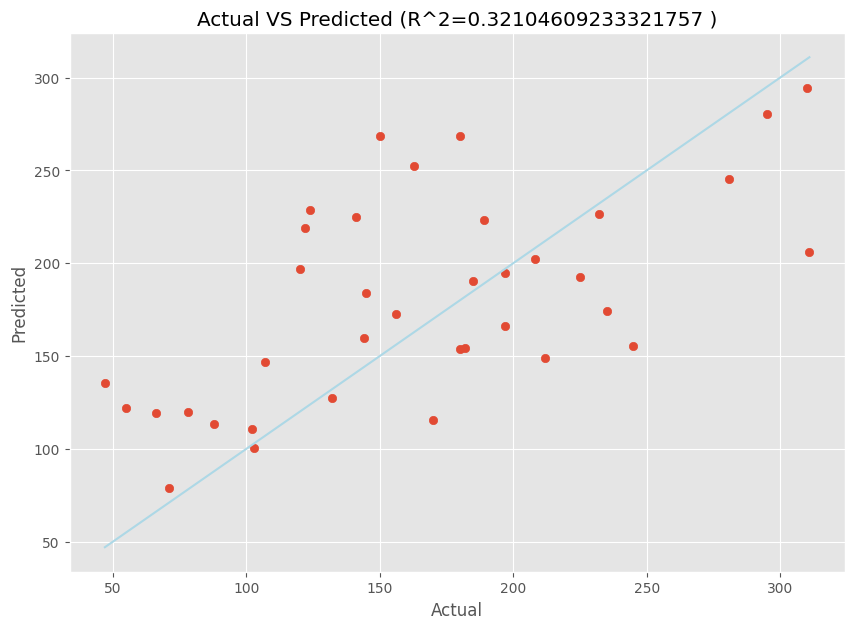

In [18]:
run = best_run.parent # Since AutoML. If manual, then keep best_run since no parent
model, val_1, val_2, val_3,val_4,val_5,reg_plt_6, val_7,class_plt_8 = controller.ESMLTestScoringFactory.get_test_scoring_8(
    p.ws,
    p.active_model["label"],
    p.GoldTest,
    fitted_model,
    run, # run or best_run
    model)

In [19]:
controller.ESMLTestScoringFactory.print_test_scoring(val_1, val_2, val_2, val_3,val_4,val_5,reg_plt_6,val_7)

RMSE = 57.08570225185653
R2 = 0.32104609233321757
MAPE = 0.32104609233321757
MAE = 0.27282048085206756
Spearman correlation = 45.332440980500316


## 6) Compare - INNER LOOP & Register with PROMOTED status, if better
 - Better than other in DEV?

In [20]:
if(best_run is not None):
    print(best_run.parent.id)
if(run is not None):    
    print(run.id)

AutoML_03534c53-e646-4372-8132-75e45d2fcaba
AutoML_03534c53-e646-4372-8132-75e45d2fcaba


In [21]:
from esmlrt.interfaces.iESMLController import IESMLController

dev_ws = p.ws
esml_current_env = "dev"
next_environment="dev"
#target_ws = controller.get_target_workspace(current_environment = esml_current_env, current_ws = dev_ws, target_environment = esml_current_env)
target_ws = dev_ws

if(run is None):
    run_id = best_run.parent.id # This is set if you just ran the TRAIN cell in this notebook. AutoMLRun in notebook - we need its parent.
else:
    run_id = run.id # Rehydrated run=parent which is set in a CELL above in this noteboo you may use. If not having a fresh training in RAM.

run_id = IESMLController.get_safe_automl_parent_run_id(run_id)
promote_new_model,source_model_name,source_run_id,source_best_run,source_model,leading_model = controller.ESMLComparer.compare_scoring_current_vs_new_model(
    new_run_id = run_id,#run_id_tag, #automl_step_run_id,
    new_model = None,
    model_name = model.name,
    current_ws = dev_ws,
    current_environment = esml_current_env,
    target_environment = next_environment,
    target_workspace = target_ws,
    experiment_name = controller.experiment_name)

if(source_best_run.id == run_id):
    print("Correct RUN found. Parent run.")

print("INNER LOOP (dev->dev) - PROMOTE?")
if (promote_new_model == True): # Better than all in DEV/Curren environment?
    model_registered_in_target = controller.register_model(source_ws=p.ws, target_env=esml_current_env, source_model=model, run=source_best_run,esml_status=IESMLController.esml_status_promoted_2_dev) 
    print("Promoted model! in environment {}".format(esml_current_env))

ESML INFO:ModelCompare: new_model is None, but new_run_id is set - trying to fetch model via hydrating RUN and model_name property
SOURCE: Trying to hydrate RUN, since DEV environment.
ESML INFO: try: automl_run or notebook_automl
Experiment name: 11_diabetes_model_reg
ws name: aml-prj001-weu-DEV-001
run_id: AutoML_03534c53-e646-4372-8132-75e45d2fcaba
 ## ESML: AutoMLRun? 
 ## ESML: AutoMLRun = TRUE
Run, best_run, fitted_model is now hydrated:
ESML: best_run.id AutoML_03534c53-e646-4372-8132-75e45d2fcaba_0
ESML: run.id AutoML_03534c53-e646-4372-8132-75e45d2fcaba
ESML test_model NAME: 11_diabetes_model_reg
ESML test_model NAME: 1
Searching with Model list LAMBDA FILTER, on experiment_name in Model.tags called: 11_diabetes_model_reg . Meaning ESML checks for both Notebook run (AutoMLRun, Run) and PipelineRuns (AutoMLStep, PipelineRun)
E.g. Even if Pipeline experiment is called '11_diabetes_model_reg_IN_2_GOLD_TRAIN' it will be included, since original model_folder_name in ESML is '11_dia

# END
- Great job! Now you have trained a model, calculated test_set scoring, compared if it is better than leading model, registered the model if so. 
- Next step would be to create a PIPELINE that does all of this. 
    - In ESML this is as easy as running this See notebook [2_PRODUCTION_phase_TRAIN_Pipeline_M10_M11.ipynb](./1_quickstart/2_PRODUCTION_phase_TRAIN_Pipeline_M10_M11.ipynb)
        - The only thing you need to change in the notebook is the `p.active_model=11` to correct model number `1` if your model has that number.
            - See  [lake_settings.json](./settings/project_specific/model/lake_settings.json) to find YOUR model number.

#### DEBUG cell - before `PROMOTE model - INNER LOOP`
- Purpose: Rehydrate Run

from azureml.train.automl.run import AutoMLRun
from azureml.core import Experiment
id_1 = best_run.parent.id

print(controller.experiment_name)
print(id_1)
exp = Experiment(p.ws,controller.experiment_name)

run = AutoMLRun(experiment=exp, run_id=id_1)
best_run, fitted_model = run.get_output()

### DEBUG cell - after a TRAIN run
- The train run, will generate a `temporary model_name (Azure ML will not update, when renamed at registration)`. The tag that Azure ML writes: `best_run.properties['model_name']`,this is NOT the correct model_name (since not same after REGISTRATION)
- Why having your OWN model name? Since we in ESML want to "lookup" if a model name already exists, under same MODEL NAME - to collect all under same model name, but with versions. 
    - Aml may create a new random name under same experiment after a couple of runs. Hence good to have your own "known". Example: Stick with the 1st generated name AML creates for you.
    - ESML also collects all models under same `experiment name TAG`, since you can TRAIN a model from a NOTEBOOK, or from a PIPELINE, and these will have different EXPERIMENT NAMES, hence using a TAG with a common name
    - All and all for MLOps: This to be able to determing BEST promoted model, and LATEST challenger model

from azureml.core import Model

my_model_name_that_exists_in_registry = "AutoMLd123123" # Look in Model registry for a model name that exists

print(best_run.id)
model_name1 = best_run.properties['model_name']
print(model_name1)

try:
    model_again = Model(p.ws, model_name1) # This will probably not be found, since this is not the registered models name, it only was the name temporary in the RUN..and is NOT updated when renamed.
    print(model_again.name)
except:
    print("could not find a registered model with name {}. This is due we CUSTOMIZE the name, when register it. This is not updated on run.properties.".format(model_name1))
    model_again = Model(p.ws, my_model_name_that_exists_in_registry) 
    print(model_again.name)  


## DEBUG cell - when SCORING pipeline runs, you pass MODEL VERSION, if VERSION=0...
...then LATEST PROMOTED model is used to score with

Below you can see how to HYDRATE the fitted_model, BEST_RUN and BEST_MODEL

model_version_in_int = 0
print("Fetching BEST MODEL that is promoted. To get its name")
current_model2,run_id_tag, model_name = IESMLController.get_best_model_via_modeltags_only_DevTestProd(p.ws,p.model_folder_name)

if(current_model2 is None):
    print("No existing model with experiment name {}. The Model name will now be same as experiment name".format(p.model_folder_name))
if(model_version_in_int == 0):
    print("Initiating BEST MODEL - PROMOTED leading model (since model_version=0). Hydrating to get its run and fitted model.")

    run_id_2 = current_model2.tags.get("run_id")
    safe_run_id = IESMLController.get_safe_automl_parent_run_id(run_id_2)
    run2,best_run2,fitted_model2 = IESMLController.init_run(p.ws,p.model_folder_name, safe_run_id)